# Training an image classifier
Packages for different kind of data:
- for images: Pillow, OpenCV
- Auios: scipy, librosa
- text: Cython, NLTK, SpaCy

`torchvision.datasets` and `torch.utils.data.DataLoader` are useful for vision

dataset for this tutorial: CIFAR10

10 classes: airplanes. automobile, bird, cat, deer, dog, frog, horse, ship, truck
images: 3*32*32

# Table of contents:
[1. Load and normalize the dataset](#1.-Load-and-normalize-the-dataset-using-torch.vision)

[2. Build a CNN](#2.-Build-a-CNN)

[3. Define a loss function and optimizer](#3.-Define-a-loss-function-and-optimizer)

[4. Training the CNN](#4.Training-the-network)

## 1. Load and normalize the dataset using `torch.vision`

In [1]:
# import library
import torch
import torchvision
import torchvision.transforms as transforms

Convert the image to tensor of normalized range[-1, 1]

In [2]:
# Normalize using 3 means and stds for 3 channels?
transform = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5 ,0.5), (0.5, 0.5, 0.5))])

# Load and transform the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(trainset.data.shape)
print(testset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Examine some images...

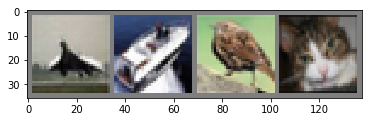

plane  ship  bird   cat


In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Function to show an image
def imshow(img):
    img = img / 2 + .5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Build a CNN

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 channels, 6 output channels, 5x5 filters
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Define a loss function and optimizer

In [6]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.

More detail in this [link](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy)

## 4.Training the network
loops over the data iterator, and feed the inputrs to the network and optimizer

In [7]:
#%%timeit
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs, data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameters gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: % 3f' %
                 (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')
        

[1,  2000] loss:  2.214806
[1,  4000] loss:  1.863183
[1,  6000] loss:  1.647357
[1,  8000] loss:  1.583365
[1, 10000] loss:  1.530504
[1, 12000] loss:  1.458657
[2,  2000] loss:  1.384219
[2,  4000] loss:  1.366682
[2,  6000] loss:  1.334222
[2,  8000] loss:  1.305635
[2, 10000] loss:  1.285185
[2, 12000] loss:  1.256193
Finished Training


In [8]:
# Save the training model's parameters
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5.Test the network on the test data
After training the network through 2 passes, we want to test wheter the network has learn anything at all.

First, display an image from the test set 

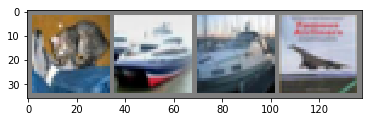

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
# Load the saved model
net = Net()
net.load_state_dict(torch.load(PATH))

# check the output of the first 4 images
outputs = net(images)

In [11]:
# print out the labels of the best predicted classes for the images
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                             for j in range(4)))

Predicted:    cat  ship   car  ship


In [12]:
# how the CNN performs on the whole dataset
correct = 0
total =0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 55 %
Accuracy of   car : 68 %
Accuracy of  bird : 41 %
Accuracy of   cat : 28 %
Accuracy of  deer : 41 %
Accuracy of   dog : 42 %
Accuracy of  frog : 75 %
Accuracy of horse : 69 %
Accuracy of  ship : 69 %
Accuracy of truck : 68 %


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

cuda:0


In [16]:
#%%timeit
#torch.backends.cudnn.enabled = False
net = net.to(device)
for epoch in range(10):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs, data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameters gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: % 3f' %
                 (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss:  1.216296
[1,  4000] loss:  1.241702
[1,  6000] loss:  1.232394
[1,  8000] loss:  1.198861
[1, 10000] loss:  1.200636
[1, 12000] loss:  1.183828
[2,  2000] loss:  1.116798
[2,  4000] loss:  1.120502
[2,  6000] loss:  1.145308
[2,  8000] loss:  1.146059
[2, 10000] loss:  1.121246
[2, 12000] loss:  1.132666
[3,  2000] loss:  1.028612
[3,  4000] loss:  1.051745
[3,  6000] loss:  1.052463
[3,  8000] loss:  1.079568
[3, 10000] loss:  1.068788
[3, 12000] loss:  1.071314
[4,  2000] loss:  0.970024
[4,  4000] loss:  1.001499
[4,  6000] loss:  1.001277
[4,  8000] loss:  1.014132
[4, 10000] loss:  1.012968
[4, 12000] loss:  1.026531
[5,  2000] loss:  0.931780
[5,  4000] loss:  0.929057
[5,  6000] loss:  0.957205
[5,  8000] loss:  0.971094
[5, 10000] loss:  0.980751
[5, 12000] loss:  0.993742
[6,  2000] loss:  0.892795
[6,  4000] loss:  0.910830
[6,  6000] loss:  0.922865
[6,  8000] loss:  0.953779
[6, 10000] loss:  0.936127
[6, 12000] loss:  0.936186
[7,  2000] loss:  0.846788
[